In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import matthews_corrcoef, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import mode

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [2]:
train_df = pd.read_csv("train.csv", index_col='id')
test_df = pd.read_csv("test.csv", index_col='id')

In [3]:
train_df.head(2)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w


In [4]:
test_df.head(2)

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,17.12,b,NaN,w,u,w,t,g,NaN,d,a
3116946,6.90,o,t,o,f,NaN,c,y,1.27,10.75,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a


In [5]:
target = 'class'

In [6]:
features = train_df.drop(target, axis=1).columns.to_list()
features

['cap-diameter',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-height',
 'stem-width',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

In [7]:
features_with_high_null_values = [feature for feature in features if (train_df[feature].isna().sum()/len(train_df)*100)>20]
features_with_high_null_values

['cap-surface',
 'gill-spacing',
 'stem-root',
 'stem-surface',
 'veil-type',
 'veil-color',
 'spore-print-color']

In [8]:
categorical_features = train_df[features].select_dtypes(include='object').columns.to_list()
categorical_features

['cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

In [9]:
numerical_features = list(set(features) - set(categorical_features))
numerical_features

['stem-height', 'cap-diameter', 'stem-width']

In [10]:
pd.concat([train_df, test_df])[categorical_features].describe(include='O').T

,count,unique,top,freq
cap-shape,5194838,108,x,2393975
cap-surface,4076982,114,t,767629
cap-color,5194884,109,n,2263849
does-bruise-or-bleed,5194891,29,f,4283405
gill-attachment,4321152,117,a,1076994
gill-spacing,3096879,66,c,2218030
gill-color,5194803,86,w,1552311
stem-root,599874,45,b,276382
stem-surface,1892560,87,s,546106
stem-color,5194850,88,w,1994002


In [11]:
def cleaner(df):
    for col in categorical_features:
        df[col] = df[col].fillna('missing')
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < 100, col] = "noise"
        df[col] = df[col].astype('category')

    return df

In [12]:
train_df = cleaner(train_df)
test_df = cleaner(test_df)

In [13]:
cap_diameter_mean = pd.concat([train_df['cap-diameter'], test_df['cap-diameter']]).mean(numeric_only=True)
train_df['cap-diameter'].fillna(cap_diameter_mean, inplace=True)
test_df['cap-diameter'].fillna(cap_diameter_mean, inplace=True)

In [14]:
X = train_df.copy()
y = X.pop(target)

lab_enc = LabelEncoder().fit(y)
y = lab_enc.transform(y)

In [15]:
def model_report(estimator, X, y, cv=5):
    print("="*80)
    print(f"    Model: {estimator.__class__.__name__}")
    print("="*80)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1/cv, shuffle=True, stratify=y, random_state=42)
    
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score: {mcc.mean():.6f}")
    
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

    print()

In [16]:
def model_trainer(model, X, y, n_splits=5, random_state=42):
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    oof_probs, oof_mccs = [], []
    print("="*80)
    print(f"Training {model.__class__.__name__}")
    print("="*80, end="\n")
    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mcc = matthews_corrcoef(y_pred, y_test)
        oof_mccs.append(mcc)
        oof_probs.append(model.predict_proba(test_df))
        print(f"--- Fold {fold+1} MCC Score: {mcc:.6f}")
    print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} \xb1 {np.std(oof_mccs):.6f}\n\n")
    return oof_probs, oof_mccs

## Baseline Models

    Model: XGBClassifier
F1 Score : 0.992358
MCC Score: 0.983147


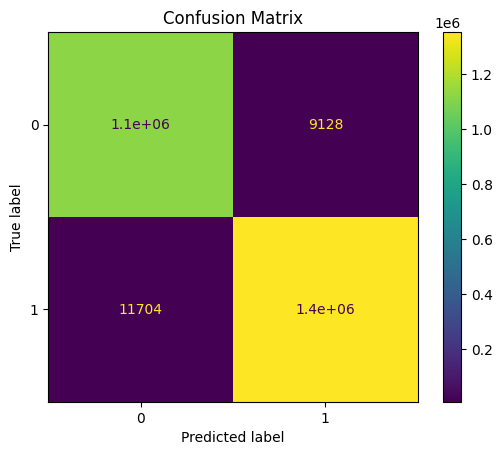

In [17]:
xgb_clf = XGBClassifier(enable_categorical=True, device="cuda", tree_method="hist")

model_report(xgb_clf, X, y)

    Model: CatBoostClassifier
F1 Score : 0.992035
MCC Score: 0.982434


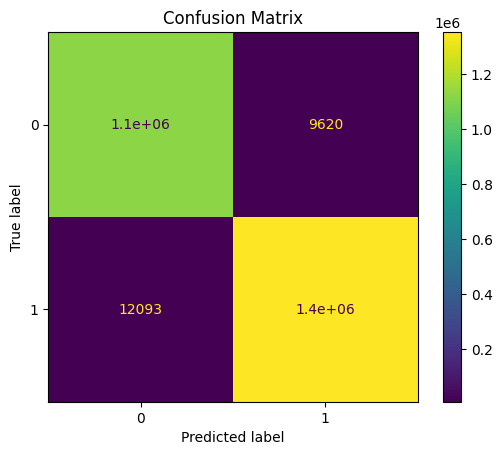

In [18]:
cat_clf = CatBoostClassifier(
    cat_features=categorical_features,
    verbose=False,
    allow_writing_files=False,
    task_type="GPU"
)

model_report(cat_clf, X, y)

    Model: LGBMClassifier
F1 Score : 0.991376
MCC Score: 0.980989


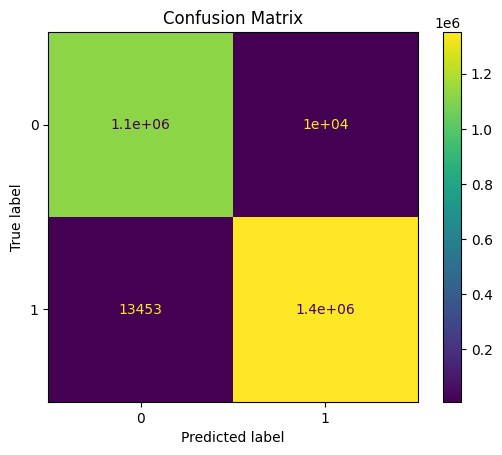

In [19]:
lgb_clf = LGBMClassifier(device='gpu', verbosity=-1)

model_report(lgb_clf, X, y)

In [20]:
xgb_params = {
    'n_estimators': 2407,
    'eta': 0.009462133032592785,
    'gamma': 0.2865859948765318,
    'max_depth': 31,
    'min_child_weight': 47,
    'subsample': 0.6956431754146083,
    'colsample_bytree': 0.3670732604094118,
    'grow_policy': 'lossguide',
    'max_leaves': 73,
    'enable_categorical': True,
    'n_jobs': -1,
    'device': 'cuda',
    'tree_method': 'hist'
} # 0.9844272567086021

cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": 'GPU',
    "cat_features": categorical_features
} # 0.9841773055825763

lgb_params = {
    'n_estimators': 2500,
    'random_state':42,
    'max_bin':1024,
    'colsample_bytree':0.6,
    'reg_lambda': 80,
#     'device': 'gpu',
    'verbosity': -1
}

## Prediction

In [38]:
oof_probs = {}
oof_probs['xgb'], _ = model_trainer(XGBClassifier(**xgb_params), X, y, random_state=101)
oof_probs['cat'], _ = model_trainer(CatBoostClassifier(**cat_params), X, y, random_state=101)
oof_probs['lgb'], _ = model_trainer(LGBMClassifier(**lgb_params), X, y, random_state=101)

Training LGBMClassifier
--- Fold 1 MCC Score: 0.985025
--- Fold 2 MCC Score: 0.984989
--- Fold 3 MCC Score: 0.984879
--- Fold 4 MCC Score: 0.984977
--- Fold 5 MCC Score: 0.984971

---> Mean MCC Score: 0.984968 ± 0.000048




In [39]:
oof_preds = {}
for model in oof_probs.keys():
    oof_preds[model] = np.argmax(np.mean(oof_probs[model], axis=0), axis=1)

# Submission

In [40]:
sub = pd.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")
preds = [pred for model, pred in oof_preds.items()]
md = mode(preds, axis=0)[0] if len(preds)>1 else preds[0]
sub[target] = lab_enc.inverse_transform(md)
sub.to_csv("submission.csv", index=False)

In [41]:
ext1 = pd.read_csv("/kaggle/input/mario-s-nightmare-15-th-place-solution/submission.csv")[target].ravel()
ext2 = pd.read_csv("/kaggle/input/ps4e8-binary-class-mathews-correlation-coeff/submission.csv")[target].ravel()
ext3 = pd.read_csv("/kaggle/input/playgrounds4e08-modeblend/submission.csv")[target].ravel()
ext4 = pd.read_csv("/kaggle/input/autogloun-t8-dslanders/submission.csv")[target].ravel()
ext5 = pd.read_csv("/kaggle/input/mario-s-nightmare-denselight-0-990/submission_test7.csv")[target].ravel()

In [42]:
preds = [ext1, ext2, ext3, ext4, ext5]

preds = [lab_enc.transform(x) for x in preds]

In [43]:
md = mode(preds, axis=0)[0]

In [44]:
sub[target] = lab_enc.inverse_transform(md)
sub.to_csv("submission.csv", index=False)